In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

In [ ]:
device = torch.device("cuda") # Defino mi device para poder usar la GPU

In [ ]:
ds = torchvision.datasets.MNIST(root = "./data", download = True, train = True) # Defino mi dataset, que lo bajo de los ds de torchvision

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4594024.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134429.57it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1091684.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3890244.80it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
ds[0] # Aplicando np.array() sobre cada primer elemento de las tuplas de ds paso la PIL image a array de numpys

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [ ]:
x_total = torch.tensor(list(map(lambda z: np.array(z[0]), ds)), dtype=torch.float32).to(device) # Convierto en tensor de tensores a la
                                                                                                # lista de primeros elementos de las tuplas de ds
y_total = (torch.nn.functional.one_hot(torch.tensor(list(map(lambda z: z[1], ds))), num_classes=10)).to(torch.float32).to(device) # Paso todos los labels convertidos en tensores a one hot encoding
                                                                                                                                  #para ver que número del 0 al 9 está siendo representado

In [ ]:
x_total.shape, y_total.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 10]))

Divido el dataset original en training y testing, creo sus loaders

In [ ]:
x_train = x_total[:50000].view(-1,1,28,28)
y_train = y_total[:50000]
x_test = x_total[50000:].view(-1,1,28,28)
y_test = y_total[50000:]

train_dataset = TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader (dataset = train_dataset, batch_size = 32, shuffle = True)
test_dataset = TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader (dataset = test_dataset, batch_size = 32, shuffle = True)


Creo el modelo


---



In [ ]:
x_train.shape

torch.Size([50000, 28, 28, 1])

In [ ]:
model = nn.Sequential(
    # Primera convolutional layer
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    # Segunda convolutional layer
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # Aplano las dos convolutional layers
    nn.Flatten(),
    nn.Linear(64 * 14 * 14, 128),
    nn.ReLU(),
    nn.Linear(128,10)
).to(device)


In [ ]:
data_iter = iter(train_loader) # Hago iterable el loader del training set
img_batch = next(data_iter) # Divido en batches aprovechando que es iterable con next()

In [ ]:
img_batch[0].shape # Verifico tamaño de los batches

torch.Size([32, 1, 28, 28])

Entreno el modelo con un loop de entrenamiento


In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
test_iter = iter(test_loader)
test_batch = next(test_iter)
num_epochs = 100
for epoch in range(num_epochs):
  for inputs, targets in tqdm(train_loader):
      inputs = inputs.to(device).float()  # Muevo entradas a la GPU y convertir a float
      targets = targets.to(device).float()
      optimizer.zero_grad()  # Reinicio gradientes acumulados
      outputs = model(inputs)  # Calculo predicciones
      loss = criterion(outputs.squeeze(), targets.float())  # Calculo la pérdida
      loss.backward()  # Retropropagación
      optimizer.step()

  correct_predictions = 0
  total_predictions = 0

  with torch.no_grad(): # Por cada epoch pruebo el accuracy del modelo con el dataset de testing
    for test_inputs, test_targets in test_loader:
      test_inputs = test_inputs.to(device).float()
      test_targets = test_targets.to(device).long()
      test_outputs = model(test_inputs)
      _, predicted = torch.max(test_outputs, 1)
      correct_predictions += (predicted == torch.argmax(test_targets, dim=1)).sum().item()
      total_predictions += test_targets.size(0)

  accuracy = (correct_predictions / total_predictions) * 100
  print(f"Accuracy: {accuracy}")






NameError: name 'nn' is not defined

Pruebo el modelo con una parte del test dataset


Predicted class: 8


<ipython-input-42-927416168881>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(image)).to(device)


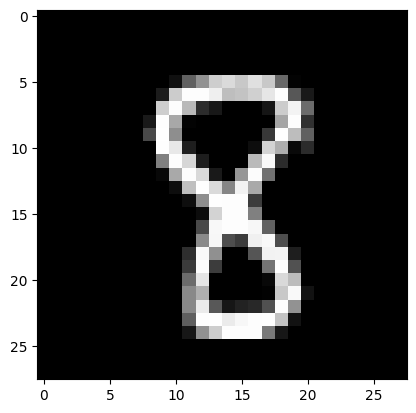

In [ ]:
image, label = test_dataset[1]
image = image.unsqueeze(0).to(device) # Le agrego una dimension en la posición 0 así pasa bien por el conv2d del modelo
# Hago la predicción desactivando el descenso de gradiente para que sea mas rapido
with torch.no_grad():
    output = model(torch.tensor(image)).to(device)

# Obtengo la clase predicha (índice de la salida con mayor valor de probabilidad, o sea el indice de qué clase tiene más probabilidad de ser la correcta)
predicted_class = output.argmax(dim=1).item()

print(f'Predicted class: {predicted_class}')
image = image.squeeze(0).cpu().numpy()  # Elimina una dimensión al batch (la agregada al principio) y mueve la imagen a la CPU

plt.imshow(image[0], cmap='gray')
plt.show()